In [1]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore")
logging.getLogger().setLevel('INFO')

## Helpers

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [3]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)

ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

C:\Users\Aziz\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

C:\Users\Aziz\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



## Tennis Match Prediction for 2017

<B> <pre>  table of contents : <br>
        1- Data visualization<br>
        2- Data pre-processing <br>
        3- Feature engineering <br>
        4- Data preparation for training<br>
        5- Training<br>
        6- 2017 predictions<br>
        7- Models evaluation<br>
        8- Conclusion <br>
        9- Proof of concept (random drop) <br>

### 1- Data visualization :

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="whitegrid")

In [9]:
def WinnersWins_percentage(df):
    #losses_tracking and cummulative_losses initialization 
    losses_tracking = dict( (k,0) for k in np.unique(np.concatenate(df[['Winner','Loser']].values)) )
    cummulative_losses = np.zeros(df.shape[0],dtype=np.int)

    for i,(winner,loser) in enumerate(df[['Winner','Loser']].values) :
        cummulative_losses[i] = losses_tracking[winner]
        #update losses tracking for winners
        losses_tracking[loser]+=1

    #cummulative wins for winners
    cummulative_wins  = df.groupby(by=['Winner']).cumcount()

    # return the percentage of victories of the winner in the pas
    return pd.Series(cummulative_wins/(cummulative_wins+cummulative_losses)).fillna(0)

In [10]:
df_atp=df_atp.sort_values('Date')
df_wta=df_wta.sort_values('Date')

df_atp.reset_index(inplace=True)
df_atp.drop('index',axis=1,inplace=True)

df_wta.reset_index(inplace=True)
df_wta.drop('index',axis=1,inplace=True)

In [11]:
df_atp['past_winner %wins'] = WinnersWins_percentage(df_atp)
df_wta['past_winner %wins'] = WinnersWins_percentage(df_wta)

C:\Users\Aziz\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Aziz\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


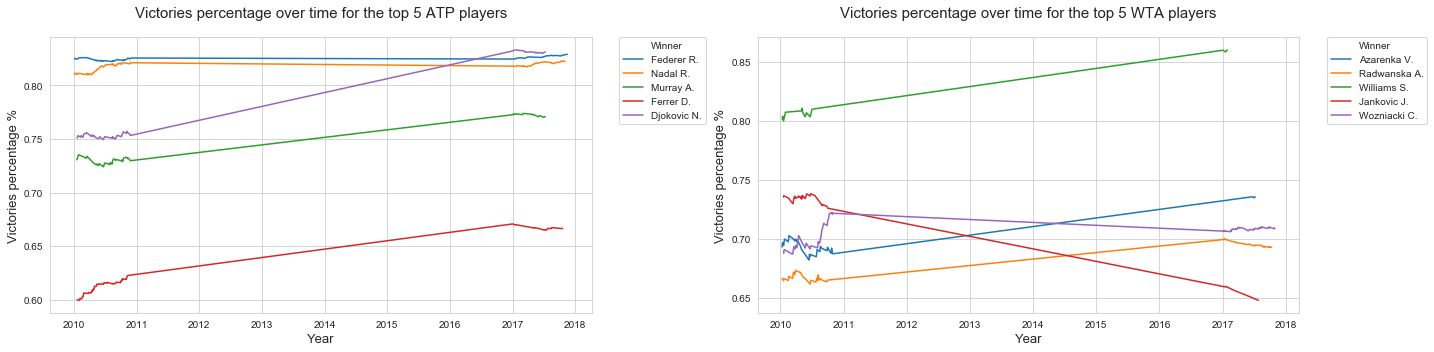

In [15]:
#sns.lineplot()
top5atp = df_atp.Winner.value_counts()[:5].keys() 
top5wta = df_wta.Winner.value_counts()[:5].keys() 
fig,axs = plt.subplots(1,2,figsize=(20,5))
ax1 = sns.lineplot(x='Date',y='past_winner %wins',ax = axs[0],
            data = df_atp[df_atp.Date.apply( lambda x : x.year in [2010,2017])][df_atp.Winner.isin(top5atp)],hue='Winner')
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.set_title('Victories percentage over time for the top 5 ATP players',pad=20,fontsize= 15)
ax1.set_xlabel('Year',fontsize= 13)
ax1.set_ylabel('Victories percentage %',fontsize= 13)

ax2 = sns.lineplot(x='Date',y='past_winner %wins',ax = axs[1],
            data = df_wta[df_wta.Date.apply( lambda x : x.year in [2010,2017])][df_wta.Winner.isin(top5wta)],hue='Winner')
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.set_title('Victories percentage over time for the top 5 WTA players',pad=20,fontsize= 15)
ax2.set_xlabel('Year',fontsize= 13)
ax2.set_ylabel('Victories percentage %',fontsize= 13)
fig.tight_layout()

Past wins percentage gives us an idea about the performance of the players, we can notice how performance of the players is encreasing or decreasing over time.<br> We can create some lag features from the victories percentage so that we can track the player's performance.

#### Top 4 players victories percentage by surface :

In [16]:
df_atp['count'] = 1
topatp = list(df_atp.Winner.value_counts()[:4].keys())
df_atpSurface = df_atp[['Winner','Surface','count']][df_atp.Winner.isin(topatp)].groupby(['Winner','Surface'],as_index=False).count()
wins  = df_atpSurface['count']
losses = df_atp[['Loser','Surface','count']][df_atp.Loser.isin(topatp)].groupby(['Loser','Surface'],as_index=False).count()['count']
df_atpSurface['%wins'] = wins/(wins+losses)

df_wta['count'] = 1
topwta = list(df_wta.Winner.value_counts()[:4].keys())
df_wtaSurface = df_wta[['Winner','Surface','count']][df_wta.Winner.isin(topwta)].groupby(['Winner','Surface'],as_index=False).count()
wins  = df_wtaSurface['count']
losses = df_wta[['Loser','Surface','count']][df_wta.Loser.isin(topwta)].groupby(['Loser','Surface'],as_index=False).count()['count']
df_wtaSurface['%wins'] = wins/(wins+losses)

In [17]:
def radar_chart(fig,player,categories,values,cols,i):
    N = len(categories)
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1,cols,i, polar=True)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=13,)
    plt.tick_params(pad=15)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,0.2,0.4,0.6,0.8,1], ['0','0.2','0.4','0.6','0.8','1'], color="grey", size=11)
    plt.ylim(0,1)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.2)
    ax.set_title(player,pad=30,fontsize= 15)

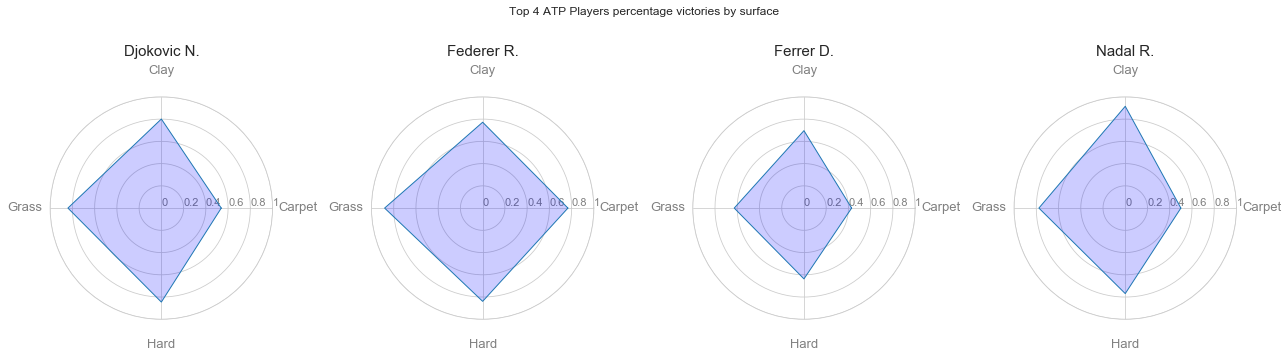

In [18]:
cols = 4
fig,axs = plt.subplots(1,1,figsize=(18,5))
categories=df_atpSurface.Surface.unique()

for i,player in enumerate(df_atpSurface.Winner.unique()):
    values = df_atpSurface[df_atpSurface.Winner == player]['%wins'].values.flatten().tolist()
    values += values[:1]
    radar_chart(fig,player,categories,values,cols,i+1)
fig.tight_layout()
fig.suptitle('Top 4 ATP Players percentage victories by surface')
fig.subplots_adjust(top=0.8)

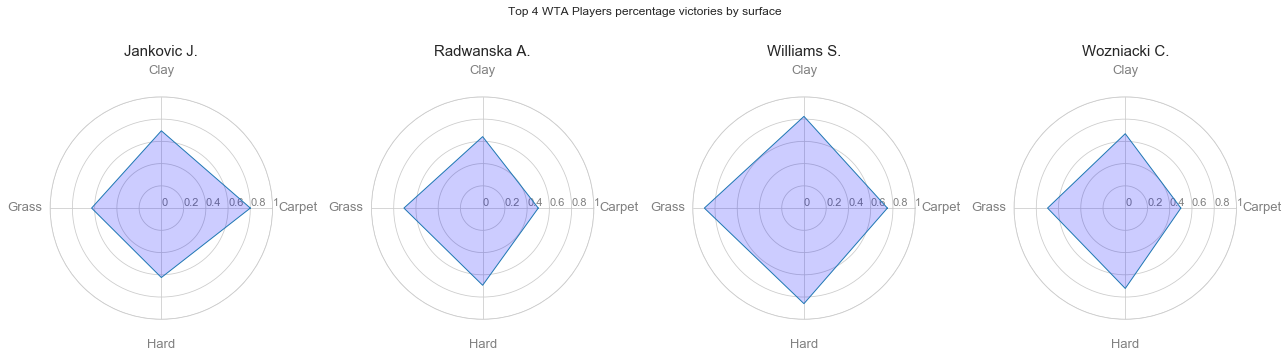

In [19]:
cols = 4
fig,axs = plt.subplots(1,1,figsize=(18,5))
categories=df_wtaSurface.Surface.unique()

for i,player in enumerate(df_wtaSurface.Winner.unique()):
    values = df_wtaSurface[df_wtaSurface.Winner == player]['%wins'].values.flatten().tolist()
    values += values[:1]
    radar_chart(fig,player,categories,values,cols,i+1)
fig.tight_layout()
fig.suptitle('Top 4 WTA Players percentage victories by surface')
fig.subplots_adjust(top=0.8)

This graph resumes the percentage victories of the top4 ATP and WTA players in different Surfaces, Novak Djokovic has less than 0.5 percent of wins on Carpet surface but has over than 0.8 percent of victories on Grass and Hard. Rafael Nadal has also less than 0.5 percent of victories on Carpet but he beats every one with a 0.9 percent of victories on Clay surface. Jankovic beats all top WTA players with the highest percentage of victories on Carpet Surface.<br> 
This is interesting, we can see how each player has his/her own surface preferences. Serena Williams and Roger Federer are the only exceptions among the top 4 WTA and ATP players, both of them reached over 0.8 percent of victories in all Surfaces and they have almost the same pattern.
We can create features that associates the percentage of victories for each player with different surfaces so that the model may recognize these patterns. 

#### Top 4 players percentage victories by top 5 tournaments :

In [20]:
topTournamentAtp = list(df_atp.Tournament.value_counts()[:5].keys())
topTournamentWta = list(df_wta.Tournament.value_counts()[:5].keys())
topatp = list(df_atp.Winner.value_counts()[:4].keys())
topwta = list(df_wta.Winner.value_counts()[:4].keys())

#atp percentage wins of the top 4 players in the top 5 tournaments
df_atpTournament = df_atp[['Winner','Tournament','count']][df_atp.Winner.isin(topatp)&(df_atp.Tournament.isin(topTournamentAtp))]\
                                                         .groupby(['Winner','Tournament'],as_index=False).count()
wins  = df_atpTournament['count']
losses = df_atp[['Loser','Tournament','count']][df_atp.Loser.isin(topatp)&(df_atp.Tournament.isin(topTournamentAtp))]\
                                                         .groupby(['Loser','Tournament'],as_index=False).count()['count']
df_atpTournament['%wins'] = wins/(wins+losses)

#wta percentage wins of the top 4 players in the top 5 tournaments
df_wtaTournament = df_wta[['Winner','Tournament','count']][df_wta.Winner.isin(topwta)&(df_wta.Tournament.isin(topTournamentWta))]\
                                                         .groupby(['Winner','Tournament'],as_index=False).count()
wins  = df_wtaTournament['count']
losses = df_wta[['Loser','Tournament','count']][df_wta.Loser.isin(topwta)&(df_wta.Tournament.isin(topTournamentWta))]\
                                                         .groupby(['Loser','Tournament'],as_index=False).count()['count']
df_wtaTournament['%wins'] = wins/(wins+losses)

In [21]:
def percenatage_plot(ax) :
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.0%}',(x + width/2, y + height*1.02), ha='center')
    return ax

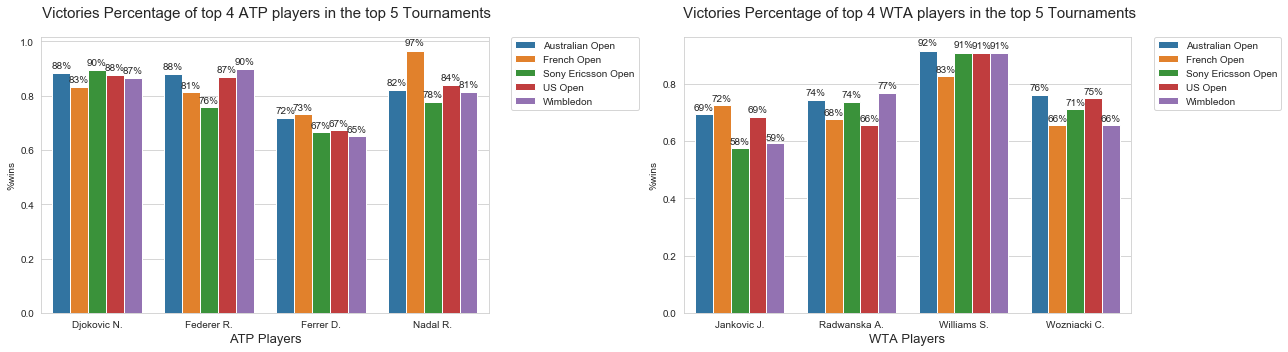

In [22]:
fig,axs = plt.subplots(1,2,figsize=(18,5))

ax0 = sns.barplot(data=df_atpTournament,x='Winner',y='%wins',hue = 'Tournament',ax=axs[0])
ax0 = percenatage_plot(ax0)
ax0.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax0.set_title(' Victories Percentage of top 4 ATP players in the top 5 Tournaments',fontsize= 15,pad=20)
ax0.set_xlabel('ATP Players',fontsize= 13)

ax1 = sns.barplot(data=df_wtaTournament,x='Winner',y='%wins',hue = 'Tournament',ax=axs[1])
ax1 = percenatage_plot(ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.set_title(' Victories Percentage of top 4 WTA players in the top 5 Tournaments',fontsize= 15,pad=20)
ax1.set_xlabel('WTA Players',fontsize= 13)
fig.tight_layout()
plt.show()

WTA and ATP players have different victories percentage in the top 5 tournaments, Which means that combining victories percentage with tournaments may also lead the model to recognize these patterns.<br> For example Rafael Nadal is unbeatable in French Open (Roland Garros) with 0.97 victory percentage, while Rodger Federer has the highest victory percentage in Wimbledon. If we relate this observation to the earlier one, everything can be justified. <br>Nadal has the highest percentage of victories in French Open because the Tournament's surface is clay and Nadal is the best player on clay surface.<br> Same for Federer, he has the highest percentage of victories in Wimbledon because he is the best player on Grass Surface, which is also the surface of Wimbledon Tournament. <br>
When it comes to the WTA players, we see the same patterns as the ATP players, except for Serena Williams. She has over 0.9 percent of victories in 4 of the top 5 tournaments.

#### Odds performance :

In [23]:
def odd_performance(oddW,oddL,n):
    performance = np.ones(n)
    i=0
    for oddw,oddl in zip(oddW,oddL):
        if type(oddl) == np.float and type(oddw) == np.float :
            if np.isnan(oddl) | np.isnan(oddw) :
                performance[i]=np.nan
            elif oddl < oddw :
                performance[i]=0
            else :
                performance[i]=1
        i+=1
    wrongOdd  = np.unique(performance,return_counts=True)[1][0]
    correctOdd  = np.unique(performance,return_counts=True)[1][1]
    return correctOdd/(correctOdd+wrongOdd)

def oddsPerformance_Dict(df,odds):
    oddsPerformance = {}
    n=len(odds)
    for i in range(0,n,2):
        oddsPerformance[odds[i][:-1]] = odd_performance(df[odds[i+1]],df[odds[i]],df.shape[0])
    return oddsPerformance

odds = ['AvgL', 'AvgW', 'B365L', 'B365W','EXL', 'EXW', 'LBL', 'LBW', 'MaxL', 'MaxW', 'PSL', 'PSW','SJL', 'SJW', 'UBL', 'UBW']
oddsPerformanceWta = oddsPerformance_Dict(df_wta,odds)
oddsPerformanceAtp = oddsPerformance_Dict(df_atp,odds)

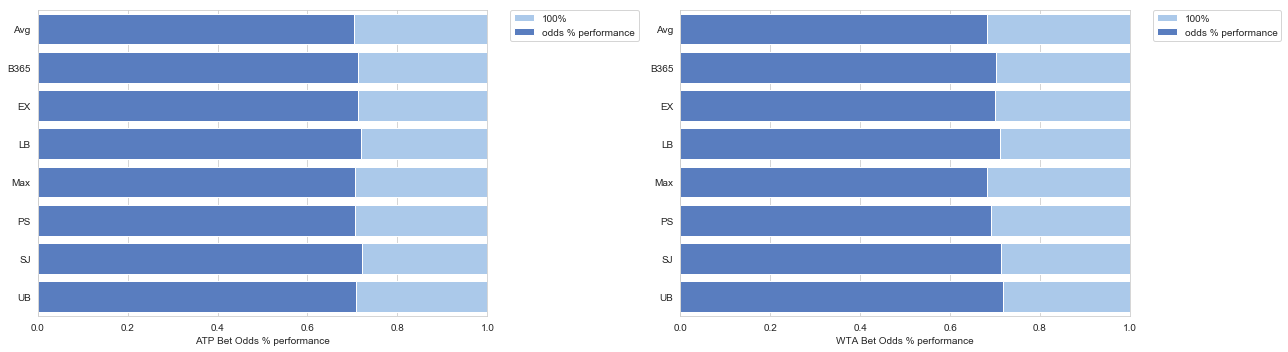

In [24]:
fig, axs = plt.subplots(1,2,figsize=(18, 5))

#axs = 0 (atp)
sns.set_color_codes("pastel")
sns.barplot(x=np.ones(len(oddsPerformanceAtp)), y=list(oddsPerformanceAtp.keys()),ax=axs[0],
            label="100%", color="b")
sns.set_color_codes("muted")
ax0=sns.barplot(x=list(oddsPerformanceAtp.values()), y=list(oddsPerformanceAtp.keys()),ax=axs[0],
            label="odds % performance", color="b")
ax0.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax0.set(xlim=(0, 1),xlabel="ATP Bet Odds % performance")

#axs = 1 (wta)
sns.set_color_codes("pastel")
sns.barplot(x=np.ones(len(oddsPerformanceWta)), y=list(oddsPerformanceWta.keys()),ax=axs[1],
            label="100%", color="b")
sns.set_color_codes("muted")
ax1=sns.barplot(x=list(oddsPerformanceWta.values()), y=list(oddsPerformanceWta.keys()),ax=axs[1],
            label="odds % performance", color="b")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.set(xlim=(0, 1),xlabel="WTA Bet Odds % performance")
fig.tight_layout()

The performance of the odds is almost the same for both ATP and WTA tennis players, their accuracy is around 0.7 , thus they are useful for the training.

In [25]:
df_wta.drop('count',axis=1,inplace=True)
df_atp.drop('count',axis=1,inplace=True)

#### Missing Values :

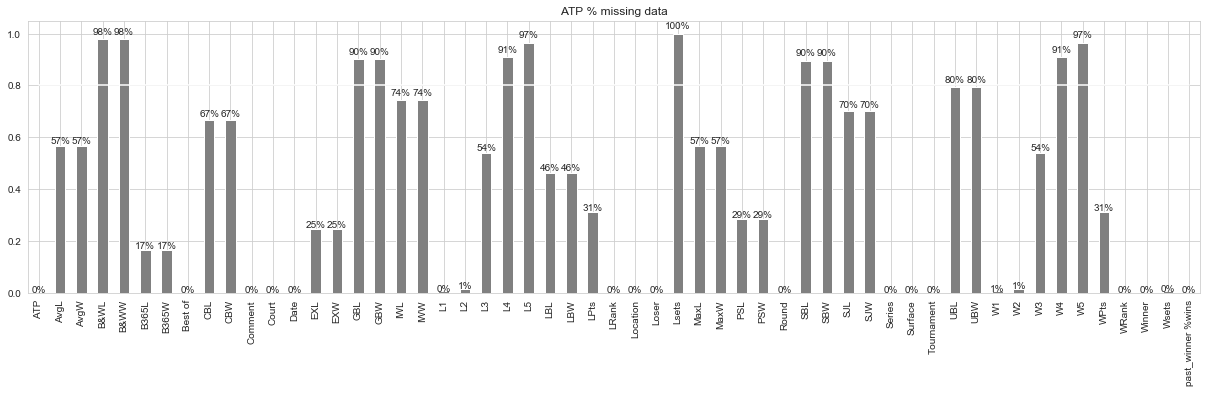

In [26]:
plt.figure(figsize=(21,5))
n = df_atp.shape[1]
ax = (df_atp.isnull().sum()/df_atp.shape[0]).plot('bar',color='grey')
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}',(x + width/2, y + height*1.02), ha='center')
plt.title('ATP % missing data')
plt.plot(np.arange(n),np.ones(n)*0.8,color = 'white')
plt.show()

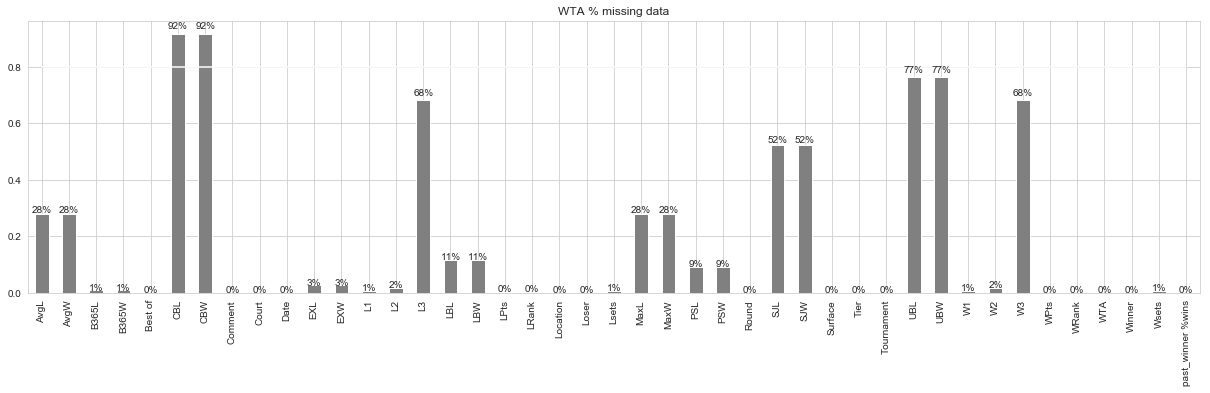

In [27]:
plt.figure(figsize=(21,5))
n = df_wta.shape[1]
ax = (df_wta.isnull().sum()/df_wta.shape[0]).plot('bar',color='grey')
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}',(x + width/2, y + height*1.02), ha='center')
plt.title('WTA % missing data')
plt.plot(np.arange(n),np.ones(n)*0.8,color = 'white')
plt.show()

### 2- Data pre-processing :

In this part, I am going to check and correct the format, range and outliers of our numerical features, then I will also check if there are any anomalies in our categorical features.

In [28]:
from tqdm import tqdm
import re

In [29]:
df_atp.shape

(52298, 55)

In [30]:
df_wta.shape

(29581, 43)

In [31]:
#over 80% atp missing values
atp_mask = ((df_atp.isnull().sum()/df_atp.shape[0])>0.8).values
df_atp.columns[atp_mask]

Index(['B&WL', 'B&WW', 'GBL', 'GBW', 'L4', 'L5', 'Lsets', 'SBL', 'SBW', 'W4',
       'W5'],
      dtype='object')

In [32]:
#over 80% wta missing values
wta_mask = ((df_wta.isnull().sum()/df_wta.shape[0])>0.8).values
df_wta.columns[wta_mask]

Index(['CBL', 'CBW'], dtype='object')

In [33]:
remove_symb = re.compile('[^.0-9]') #check if there is anything else than "." and digits
remove_multi_dots = re.compile('\.\.+')     #remove multiple dots between numbers

#correct digits
def correction(x,pattern,replace):
    '''
    a functions that check pattern and replaces any detected anomalies.

    Parameters
    ----------
    x : a string
    pattern: a compiled regular expression pattern
    replace: a string or character that will be replaced

    Returns
    -------
    x : a string
    '''
    for match in re.findall(pattern,x) :
        x=x.replace(match,replace)
    x = re.sub(remove_multi_dots,'.',x)
    return x

In [34]:
# this function checks and replaces data with regard to some patterns by the execution of "correction" function
def check_replace(df,features,replace,pattern):
    for feature in tqdm(features) :
        if feature in df.columns:
                df[feature] = df[feature].astype(str) \
                                         .apply(lambda x : correction(x,pattern,replace) if correction(x,pattern,replace)!='' else None )\
                                         .astype(float)
    return df

In [35]:
#select numerical features
numFeatures_wta = df_atp.drop(['ATP','Comment','Court','Date','Location','Round','Series','Surface','Tournament','Winner','Loser'],axis=1).columns
numFeatures_atp = df_atp.drop(['ATP','Comment','Court','Date','Location','Round','Series','Surface','Tournament','Winner','Loser'],axis=1).columns

#apply functions for numerical features
df_wta = check_replace(df_wta,numFeatures_wta,'',remove_symb)
df_atp = check_replace(df_atp,numFeatures_atp,'',remove_symb)

100%|██████████| 44/44 [00:11<00:00,  3.88it/s]


In [36]:
#check range : 0 to 7 for games in each set
check_range = lambda df,limit,feature : df[feature].apply(lambda x : x if x <= limit else None)

#l1/w1 --> l1/w5 for atp players : 
for i in range(1,6) :
    df_atp['L'+str(i)] = check_range(df_atp,7,'L'+str(i))
    df_atp['W'+str(i)] = check_range(df_atp,7,'W'+str(i))

#l1/w1 --> l3/w3 for wta players :
for i in range(1,4) :
    df_wta['L'+str(i)] = check_range(df_wta,7,'L'+str(i))
    df_wta['W'+str(i)] = check_range(df_wta,7,'W'+str(i))

In [37]:
def Odds_threshold(df,eps,features):
    '''
    a functions that replaces outliers with nans using a certain threshold

    Parameters
    ----------
    df  : DataFrame.
    eps : a factor used to calculate the threshold like (eps*std)+mean
    features : numerical feature labels
    Returns
    -------
    df : DataFrame 
    '''
    for feature in features :
        std = df[feature].std()
        mean= df[feature].mean()
        threshold = mean+(eps*std) #the threshold is 1.5*std of each odd distribution
        df[feature] = df[feature].apply(lambda x : None if x>threshold or x<0 else x )
    return df

In [38]:
#regularize atp odds
odds_atp = ['AvgL', 'AvgW', 'B365L', 'B365W', 'CBL', 'CBW',
            'EXL', 'EXW', 'IWL', 'IWW','LBL', 'LBW','MaxL',
            'MaxW', 'PSL', 'PSW','SJL', 'SJW','UBL', 'UBW']
df_atp = Odds_threshold(df_atp,1.5,odds_atp)

#MaxL still contains high values
eps = 1.5
std = df_atp['MaxL'].std()
mean= df_atp['MaxL'].mean()
threshold = mean+(eps*std)   #the threshold is 1.5*std of MaxL distribution
df_atp['MaxL'] = df_atp['MaxL'].apply(lambda x : None if x>threshold or x<0 else x )

In [39]:
#regularize wta odds
odds_wta = ['AvgL', 'AvgW', 'B365L', 'B365W',
            'EXL', 'EXW','LBL', 'LBW','MaxL','MaxW', 'PSL', 'PSW','SJL',
            'SJW','UBL', 'UBW']
df_wta = Odds_threshold(df_wta,1.5,odds_wta)

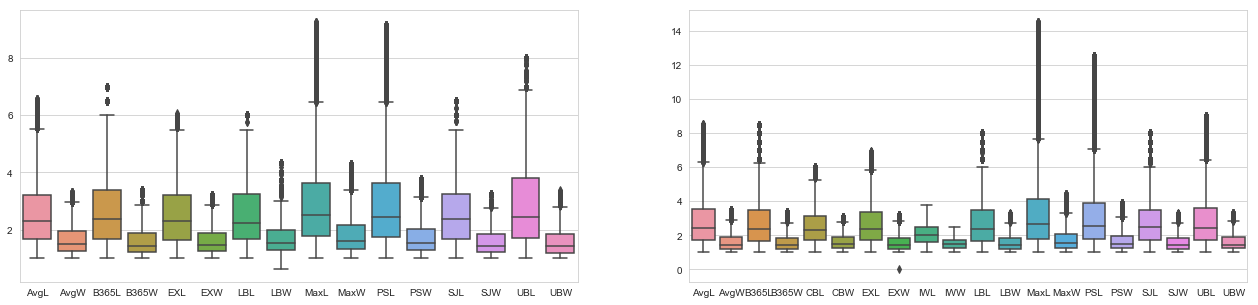

In [40]:
 #checking outliers and ditributions of the odds after the correction
fig,axs = plt.subplots(1,2,figsize=(22,5))
sns.boxplot(data=df_wta[odds_wta],ax=axs[0])
sns.boxplot(data=df_atp[odds_atp],ax=axs[1])
plt.show()

In [41]:
df_atp['Best of'].value_counts()

3.0    42561
5.0     9737
Name: Best of, dtype: int64

In [42]:
df_wta['Best of'].value_counts()

3.0    29580
5.0        1
Name: Best of, dtype: int64

In [43]:
#wta should only have best of 3 sets 
df_wta['Best of'] = 3

### 3- Feature engineering  :

In [44]:
def label_encoder(encoder,df):
    '''
    a function that filters object data types to encode them

    Parameters
    ----------
    df : DataFrame.
    encoder: label encoder instance.
    
    Returns
    -------
    df : DataFrame
    '''
    for feature in df.columns :
        if df[feature].dtype == object : 
            df[feature]=lb_encoder.fit_transform(df[feature])
    return df

In [45]:
def featuresSwap(df,swap_features,target,cond=1):
    '''
    a function that swap winner and losers faetures by axis=0

    Parameters
    ----------
    df : DataFrame
    swap_features: list of tuples [(loser feature,winner feature),...]
    target: a consecutive 0,1 int vector
    cond: the condition to swap features with regard to the target
    
    Returns
    -------
    df_out : DataFrame
    '''
    df_out = df.copy()    
    for loser_ftr,winner_ftr in swap_features : 
        df_out[winner_ftr] = df[winner_ftr].where(df[target] == cond, df[loser_ftr])
        df_out[loser_ftr]  = df[loser_ftr].where(df[target] == cond, df[winner_ftr])
    return df_out

In [46]:
def past_percentage(df,targetLabel,outFeatureLabel,*groupByFtr):
    '''
    a function that calculates the past percentage of victories for all players grouped by one or multiple features
    
    Parameters
    ----------
    df : DataFrame.
    targetLabel : label of the feature that indicates if a player wins
    outFeatureLabel : label of the output feature
    
    *groupByFtr: one or multiple features for grouping 
    '''
    cum_sum   = df.groupby(groupByFtr).cumsum()[targetLabel]
    cum_count = df.groupby(groupByFtr).cumcount()+1
    percentage = cum_sum/cum_count
    df[outFeatureLabel] = percentage
    df[outFeatureLabel] = df.groupby(groupByFtr)[outFeatureLabel].shift()

#### Merge wta and atp datasets

In [47]:
df_wta.rename({'Tier':'Series'},axis=1,inplace=True)

In [48]:
drop_ftrs = ['B&WL', 'B&WW', 'GBL', 'GBW','SBL', 'SBW','L4','W4','L5','W5','CBL', 'CBW','IWL','IWW','ATP','WTA']
for ftr in drop_ftrs :
    if ftr in df_atp.columns:
        df_atp.drop(ftr,axis=1,inplace=True)
    if ftr in df_wta.columns:
        df_wta.drop(ftr,axis=1,inplace=True)

In [49]:
df_atp['competition'] = 'atp'
df_wta['competition'] = 'wta'

In [50]:
tennis = pd.concat([df_wta,df_atp],axis=0)
tennis.sort_values('Date',inplace=True)
tennis.reset_index(inplace=True)
tennis.drop('index',axis=1,inplace=True)
tennis.shape

(81879, 41)

#### Data Duplication 

For the next part, I am going to generate some features like head to head, past victories for all players by surface or tournaments and lags features that may be useful later for our model.<br>
In order to generate such features I am going to execute some groupby instructions, the problem here is that I have to track at each time the players wins and losses. these two information are separated in two dimensions Winner and Loser which makes generating such features a bit hard and can't be done with a simple grouping instruction.<br> 
An easy example to show how ugly things can be for the feature engineering process is the "WinnersWins_percentage" function that I created earlier to generate the percentage victories of the winners.<br>
An easy way to generate these features with a simple and clean code is to gather the wins and losses information for the first player in one feature that we'll label it player1 wins and the same exact thing for player2 in a feature labeled player2 wins.<br>
For this purpose, I am going to duplicate each row and swap the winner/loser features than add another two features that indicates at each row which of the players is the winner(player1 wins and player2 wins).<br>
After this process is done, we can easily group by players and get their wins percentage, head to head features percentage and lags features.

In [51]:
tennis.drop_duplicates(inplace=True)

In [52]:
swap_features = [('AvgL','AvgW'),('B365L', 'B365W'),('UBL', 'UBW'),('EXL', 'EXW'),('MaxL', 'MaxW'),
                 ('PSL', 'PSW'),('SJL', 'SJW'),('LBL', 'LBW'),('LPts','WPts'),('LRank','WRank'),
                 ('Lsets','Wsets'),('Loser','Winner'),('L1','W1'),('L2','W2'),('L3','W3')]

In [53]:
#duplicate each row
new_tennis = pd.DataFrame(np.repeat(tennis.values,2,axis=0))
new_tennis.columns = tennis.columns


#create our target (tracks winner and loser for both players)
target1 = np.ones(new_tennis.shape[0])
target2 = np.zeros(new_tennis.shape[0])
target1[::2],target2[::2] = 0,1
new_tennis['player1 wins'] = target1
new_tennis['player2 wins'] = target2

#swap each duplicated row
new_tennis = featuresSwap(new_tennis,swap_features,'player1 wins')

In [54]:
new_tennis = new_tennis.convert_objects()

In [55]:
rename = {}
rename['LPts'] = 'p2 pts'
rename['WPts'] = 'p1 pts'
rename['WRank'] = 'p1 rank'
rename['LRank'] = 'p2 rank'
rename['Lsets'] = 'p2 wonSets'
rename['Wsets'] = 'p1 wonSets'
rename['Loser'] = 'player2'
rename['Winner'] = 'player1'

for (loser,winner) in swap_features[:-7] :
    rename[loser]  = 'p2 '+loser[:-1]
    rename[winner] = 'p1 '+winner[:-1]

for (loser,winner) in swap_features[-3:] :
    rename[loser]  = 'p2 gamesWonSet'+loser[-1]
    rename[winner] = 'p1 gamesWonSet'+winner[-1]
    
new_tennis.rename(rename,axis=1,inplace=True)
new_tennis.columns

Index(['p2 Avg', 'p1 Avg', 'p2 B365', 'p1 B365', 'Best of', 'Comment', 'Court',
       'Date', 'p2 EX', 'p1 EX', 'p2 gamesWonSet1', 'p2 gamesWonSet2',
       'p2 gamesWonSet3', 'p2 LB', 'p1 LB', 'p2 pts', 'p2 rank', 'Location',
       'player2', 'p2 wonSets', 'p2 Max', 'p1 Max', 'p2 PS', 'p1 PS', 'Round',
       'p2 SJ', 'p1 SJ', 'Series', 'Surface', 'Tournament', 'p2 UB', 'p1 UB',
       'p1 gamesWonSet1', 'p1 gamesWonSet2', 'p1 gamesWonSet3', 'p1 pts',
       'p1 rank', 'player1', 'p1 wonSets', 'competition', 'past_winner %wins',
       'player1 wins', 'player2 wins'],
      dtype='object')

In [56]:
#I have already created this feature for atp and wta winners.
#I am deleting it to create another one that tracks past percentage wins for both losers and winners
new_tennis.drop('past_winner %wins',axis=1,inplace=True)

In [57]:
tennis[['Winner','Loser','WRank','LRank','WPts','LPts','B365W','B365L','Series','Tournament']].tail(5)

,Winner,Loser,WRank,LRank,WPts,LPts,B365W,B365L,Series,Tournament
81874,Djokovic N.,Anderson K.,1.0,6.0,8045.0,4310.0,1.11,7.00,Masters Cup,Masters Cup
81875,Zverev A.,Federer R.,5.0,3.0,5085.0,6020.0,3.20,1.36,Masters Cup,Masters Cup
81876,Zverev A.,Djokovic N.,5.0,1.0,5085.0,8045.0,NaN,1.14,Masters Cup,Masters Cup
81877,Groth J.,Kudryavtseva A.,55.0,103.0,1105.0,666.0,1.16,4.50,International,Landsky Lighting Guangzhou International Women...
81878,Li N.,Kerber A.,9.0,7.0,3795.0,5225.0,1.80,2.00,Premier,Western & Southern Financial Group Women's Open


In [58]:
new_tennis[['player1','player2','p1 rank','p2 rank','p1 pts','p2 pts','p1 B365', 'p2 B365','Series','Tournament','player1 wins','player2 wins']].tail(10)


,player1,player2,p1 rank,p2 rank,p1 pts,p2 pts,p1 B365,p2 B365,Series,Tournament,player1 wins,player2 wins
163748,Anderson K.,Djokovic N.,6.0,1.0,4310.0,8045.0,7.00,1.11,Masters Cup,Masters Cup,0.0,1.0
163749,Djokovic N.,Anderson K.,1.0,6.0,8045.0,4310.0,1.11,7.00,Masters Cup,Masters Cup,1.0,0.0
163750,Federer R.,Zverev A.,3.0,5.0,6020.0,5085.0,1.36,3.20,Masters Cup,Masters Cup,0.0,1.0
163751,Zverev A.,Federer R.,5.0,3.0,5085.0,6020.0,3.20,1.36,Masters Cup,Masters Cup,1.0,0.0
163752,Djokovic N.,Zverev A.,1.0,5.0,8045.0,5085.0,1.14,NaN,Masters Cup,Masters Cup,0.0,1.0
163753,Zverev A.,Djokovic N.,5.0,1.0,5085.0,8045.0,NaN,1.14,Masters Cup,Masters Cup,1.0,0.0
163754,Kudryavtseva A.,Groth J.,103.0,55.0,666.0,1105.0,4.50,1.16,International,Landsky Lighting Guangzhou International Women...,0.0,1.0
163755,Groth J.,Kudryavtseva A.,55.0,103.0,1105.0,666.0,1.16,4.50,International,Landsky Lighting Guangzhou International Women...,1.0,0.0
163756,Kerber A.,Li N.,7.0,9.0,5225.0,3795.0,2.00,1.80,Premier,Western & Southern Financial Group Women's Open,0.0,1.0
163757,Li N.,Kerber A.,9.0,7.0,3795.0,5225.0,1.80,2.00,Premier,Western & Southern Financial Group Women's Open,1.0,0.0


#### Date features :

In [59]:
#Date : 
new_tennis = new_tennis[new_tennis.Date.dt.year<=2017]

new_tennis['Year']  = new_tennis.Date.dt.year
new_tennis['Month'] = new_tennis.Date.dt.month
new_tennis['Day']   = new_tennis.Date.dt.day

#drop date
new_tennis.drop('Date',axis=1,inplace=True)

#### Past percentage wins features

In [60]:
#past percentage wins for all players
past_percentage(new_tennis,'player1 wins','past p1 %wins','player1')
past_percentage(new_tennis,'player2 wins','past p2 %wins','player2')

#past percentage wins (by player/surface) for all players
past_percentage(new_tennis,'player1 wins','past p1 %winsBySurface','player1','Surface')
past_percentage(new_tennis,'player2 wins','past p2 %winsBySurface','player2','Surface')

#past percentage wins (by player/Tournament) for all players
past_percentage(new_tennis,'player1 wins','past p1 %winsByTournament','player1','Tournament')
past_percentage(new_tennis,'player2 wins','past p2 %winsByTournament','player2','Tournament')

#### Lag by year

In [61]:
#4 years lag
lag = 4 

#Rank lag by year :
#player1
for i in range(lag):
    new_tennis['p1 rankLag{}Y'.format(i+1)] = new_tennis[['Year','player1','p1 rank']].groupby(['Year','player1']).shift(i+1)
#player2
for i in range(lag):
    new_tennis['p2 rankLag{}Y'.format(i+1)] = new_tennis[['Year','player2','p2 rank']].groupby(['Year','player2']).shift(i+1)

In [62]:
#Points lag by year
#player1
for i in range(lag):
    new_tennis['p1 ptsLag{}Y'.format(i+1)] = new_tennis[['Year','player1','p1 pts']].groupby(['Year','player1']).shift(i+1)
#player2
for i in range(lag):
    new_tennis['p2 ptsLag{}Y'.format(i+1)] = new_tennis[['Year','player2','p2 pts']].groupby(['Year','player2']).shift(i+1)

#### Lag by last match played

In [63]:
#5 last match played 
lag = 5 

#last 5 match played (percentage wins)
#player1
for i in range(lag):
    new_tennis['p1 %wins{}MP'.format(i+1)] = new_tennis[['player1','past p1 %wins']].groupby(['player1']).shift(i+1)
#player2
for i in range(lag):
    new_tennis['p2 %wins{}MP'.format(i+1)] = new_tennis[['player2','past p2 %wins']].groupby(['player2']).shift(i+1)

In [64]:
#last 5 match played (percentage wins by player/surface)
#player1
for i in range(lag):
    new_tennis['p1 %winsSurface{}MP'.format(i+1)] = new_tennis[['player1','Surface','past p1 %wins']].groupby(['player1','Surface']).shift(i+1)
#player2
for i in range(lag):
    new_tennis['p2 %winsSurface{}MP'.format(i+1)] = new_tennis[['player2','Surface','past p2 %wins']].groupby(['player2','Surface']).shift(i+1)

In [65]:
#last 5 match played (percentage wins by player/tournament)
#player1
for i in range(lag):
    new_tennis['p1 %winsTournament{}MP'.format(i+1)] = new_tennis[['player1','Tournament','past p1 %wins']].groupby(['player1','Tournament']).shift(i+1)
#player2
for i in range(lag):
    new_tennis['p2 %winsTournament{}MP'.format(i+1)] = new_tennis[['player2','Tournament','past p2 %wins']].groupby(['player2','Tournament']).shift(i+1)

#### Past head to head statistics : (past wins percentage)

In [66]:
#h2h features :
h2h_features = ['player2','player1','p2 wonSets','p1 wonSets','p2 gamesWonSet1','p1 gamesWonSet1','p2 gamesWonSet2','p1 gamesWonSet2',
                'p2 gamesWonSet3','p1 gamesWonSet3']

h2h_cumsum   = new_tennis[h2h_features].groupby(['player1','player2']).cumsum().values
h2h_cumcount = (new_tennis[h2h_features].groupby(['player1','player2']).cumcount()+1).values
h2h_cumcount = np.repeat(h2h_cumcount,6).reshape((new_tennis.shape[0],6))

In [67]:
#games past wins percentage
games_ratio = h2h_cumsum[:,2:]/(h2h_cumcount*7)
for i,feature in enumerate(h2h_features[4:]) :
    new_tennis[feature] = games_ratio[:,i]
new_tennis[h2h_features[4:]] =  new_tennis[h2h_features].groupby(['player1','player2'])[h2h_features[4:]].shift()

In [68]:
#sets past wins percentage
sets_cumsum = np.repeat(h2h_cumsum[:,:2].sum(axis=1),2).reshape((new_tennis.shape[0],2))
sets_ratio  = h2h_cumsum[:,:2]/sets_cumsum
for i,feature in enumerate(h2h_features[2:4]) :
    new_tennis[feature] = sets_ratio[:,i]

new_tennis[h2h_features[2:]] = new_tennis[h2h_features].groupby(['player1','player2'])[h2h_features[2:]].shift()

#### Difference features :

In [69]:
#difference between players (points and ranks)
new_tennis['diff_Rank'] = new_tennis['p1 rank'] - new_tennis['p2 rank'] 
new_tennis['diff_Pts']  = new_tennis['p1 pts'] - new_tennis['p2 pts']

In [70]:
new_tennis.shape

(153574, 98)

In [71]:
new_tennis.columns

Index(['p2 Avg', 'p1 Avg', 'p2 B365', 'p1 B365', 'Best of', 'Comment', 'Court',
       'p2 EX', 'p1 EX', 'p2 gamesWonSet1', 'p2 gamesWonSet2',
       'p2 gamesWonSet3', 'p2 LB', 'p1 LB', 'p2 pts', 'p2 rank', 'Location',
       'player2', 'p2 wonSets', 'p2 Max', 'p1 Max', 'p2 PS', 'p1 PS', 'Round',
       'p2 SJ', 'p1 SJ', 'Series', 'Surface', 'Tournament', 'p2 UB', 'p1 UB',
       'p1 gamesWonSet1', 'p1 gamesWonSet2', 'p1 gamesWonSet3', 'p1 pts',
       'p1 rank', 'player1', 'p1 wonSets', 'competition', 'player1 wins',
       'player2 wins', 'Year', 'Month', 'Day', 'past p1 %wins',
       'past p2 %wins', 'past p1 %winsBySurface', 'past p2 %winsBySurface',
       'past p1 %winsByTournament', 'past p2 %winsByTournament',
       'p1 rankLag1Y', 'p1 rankLag2Y', 'p1 rankLag3Y', 'p1 rankLag4Y',
       'p2 rankLag1Y', 'p2 rankLag2Y', 'p2 rankLag3Y', 'p2 rankLag4Y',
       'p1 ptsLag1Y', 'p1 ptsLag2Y', 'p1 ptsLag3Y', 'p1 ptsLag4Y',
       'p2 ptsLag1Y', 'p2 ptsLag2Y', 'p2 ptsLag3Y', 'p2 ptsLa

### 4- Data preparation for training :

In [72]:
from sklearn.preprocessing import LabelEncoder

This part is crucial for our next steps (training  and evaluation), as we are going to encode object features then we will generate a random vector that has only zeros and ones, as we know our data has been duplicated, we have a winner vs loser and loser vs winner of the same match at each two rows.<br>
At this point our train data still contain the information of who is the winner and loser at each row, in order that our modern learns patterns from our data we must first lose this information before we pass to the training process. <br>
An easy way to do so, is to generate a random vector with zeros and ones, then we create a policy that for each match it deletes the first row (winner vs loser) if the vector contains one and leave the over duplicated row and do the exact opposite thing when the vector contains 0.<br>
At the end of the process, if our generated vector's length is half the duplicated data, and if we will drop one of two duplicated rows for each match depending on the value of the vector at each time, we will finally have a data set without any duplicated rows and we will lose the pattern of winner vs loser or loser vs winner, but this information is still preserved in our features player1 wins and player2 wins. when we will train our model we will only use one of these two features as a target and drop the other one.<br>
In this way it doesn't matter which player you are going to pass it first when you're going to predict the winner, the order simply doesn't matter for our model.

In [73]:
# label encoding : 
lb_encoder = LabelEncoder()
players    = new_tennis['player1'].unique()

#encoding of player 1 and player2
lb_encoder.fit(players)
new_tennis.player1 = lb_encoder.transform(new_tennis.player1)
new_tennis.player2 = lb_encoder.transform(new_tennis.player2)

#this feature will keep us tracking atp and wta games
new_tennis.competition = new_tennis.competition.apply(lambda x : 1 if x=='atp' else 0)

#encoding of the remaining object type features 
new_tennis = label_encoder(lb_encoder,new_tennis)

In [74]:
#new_tennis_copy is going to be used after training to prove that random swap won't have a huge effect on training
new_tennis_copy = new_tennis.copy()

In [77]:
#generate a random vector of 0 and 1 
n = int(new_tennis.shape[0]/2)
#fix the seed to 123
np.random.seed(seed=123)

randomVector = np.random.randint(0,2,n)

In [78]:
np.unique(randomVector,return_counts=True)

(array([0, 1]), array([38488, 38299], dtype=int64))

In [ ]:
#for each match presented in two consecutive rows (player1 vs player2) and (player2 vs player1)
#I will drop one row of them, the process is simple at each step=2 if the value in randomVector is 1 I will drop the first row (player1 vs player2)
#and if the value is 0 I will drop the second row of the match (player2 vs player1)

drop_index = np.zeros(n,dtype=np.int)
j=0
for i in range(0,new_tennis.shape[0],2):
    if randomVector[j] == 1 :
        drop_index[j] = i
    else :
        drop_index[j] = i+1        
    j+=1
    
new_tennis.drop(index=drop_index,axis=0,inplace=True)
new_tennis.shape

### 5- Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc,accuracy_score

In [ ]:
def train_test_split(df,test_year,target):
    return  df[df.Year<test_year].drop(target,axis=1),\
            df[df.Year==test_year].drop(target,axis=1),\
            df[df.Year<test_year][target],\
            df[df.Year==test_year][target]

In [ ]:
#models
xgb = XGBClassifier(learning_rate=0.033, max_depth=5, gamma=0,colsample_bytree=0.6,colsample_bylevel=0.9,subsample=1,n_estimators=1000,n_jobs=-1)
rf  = RandomForestClassifier(n_estimators=1000,max_depth=6,n_jobs=-1,bootstrap=True)
lg  = LogisticRegression(penalty='l2',tol=0.001,C=1.33,max_iter=300)

In [84]:
#I can choose player2 wins or player1 wins as a target for our model
#I have chosen player1 wins, my model is going to predict wether player1 will win or not, in that case I must drop player2 wins from tennis to avoid any data leakage
if 'player2 wins' in new_tennis.columns :
    new_tennis.drop('player2 wins',axis=1,inplace=True)

In [79]:
###### cross validation 5 folds
folds  = 5
n_models = 3
modelLabels = ['xgBoost            ','random Forest      ','logestic Regression']

year_start = 2012
accuracyCV    = np.zeros((folds,n_models))
wtaAccuracyCV = np.zeros((folds,n_models))
atpAccuracyCV = np.zeros((folds,n_models))

for fold in range(folds):
    year = year_start + fold
    print('fold number {}        :'.format(fold+1),'       train : 2000 -> ',year-1,' |  validation : ',year)
    
    X_train,X_test,y_train,y_test = train_test_split(new_tennis,year,'player1 wins')
    atpMask = X_test.competition.apply(lambda x : True if x == 1 else False )
    wtaMask = X_test.competition.apply(lambda x : True if x == 0 else False )
    
    xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='auc',verbose=False,early_stopping_rounds=30)
    rf.fit(X_train.fillna(9999),y_train)
    lg.fit(X_train.fillna(9999),y_train)
    
    ypred_xgb = xgb.predict(X_test,ntree_limit=0)
    ypred_rf  = rf.predict(X_test.fillna(9999))
    ypred_lg  = lg.predict(X_test.fillna(9999))
    
    predictions = [ypred_xgb,ypred_rf,ypred_lg]
    for j in range(n_models):
        accuracyCV[fold,j]    = accuracy_score(predictions[j],y_test)
        atpAccuracyCV[fold,j] = accuracy_score(predictions[j][atpMask],y_test[atpMask])
        wtaAccuracyCV[fold,j] = accuracy_score(predictions[j][wtaMask],y_test[wtaMask])
        print(modelLabels[j],' :  overall accuracy = {:.2%}'.format(accuracyCV[fold,j]),
                            '\t atp accuracy = {:.2%}'.format(atpAccuracyCV[fold,j]),
                            '\t wta accuracy = {:.2%}'.format(wtaAccuracyCV[fold,j]))
    print('\n------------------------------------------------------------------------------------\n')

fold number 1        :        train : 2000 ->  2011  |  validation :  2012
xgBoost              :  overall accuracy = 76.98% 	 atp accuracy = 78.01% 	 wta accuracy = 75.86%
random Forest        :  overall accuracy = 74.57% 	 atp accuracy = 75.92% 	 wta accuracy = 73.08%
logestic Regression  :  overall accuracy = 68.27% 	 atp accuracy = 69.21% 	 wta accuracy = 67.23%

------------------------------------------------------------------------------------

fold number 2        :        train : 2000 ->  2012  |  validation :  2013
xgBoost              :  overall accuracy = 75.97% 	 atp accuracy = 75.76% 	 wta accuracy = 76.20%
random Forest        :  overall accuracy = 73.84% 	 atp accuracy = 73.99% 	 wta accuracy = 73.68%
logestic Regression  :  overall accuracy = 70.06% 	 atp accuracy = 70.21% 	 wta accuracy = 69.89%

------------------------------------------------------------------------------------

fold number 3        :        train : 2000 ->  2013  |  validation :  2014
xgBoost      

In [80]:
print('cross validation mean accuracy :\n')
for j in range(n_models):
    print(modelLabels[j],' :  overall accuracy = {:.2%}'.format(accuracyCV[:,j].mean()),
                        '\t atp accuracy = {:.2%}'.format(atpAccuracyCV[:,j].mean()),
                        '\t wta accuracy = {:.2%}'.format(wtaAccuracyCV[:,j].mean()))

cross validation mean accuracy :

xgBoost              :  overall accuracy = 75.77% 	 atp accuracy = 76.81% 	 wta accuracy = 74.68%
random Forest        :  overall accuracy = 74.16% 	 atp accuracy = 75.43% 	 wta accuracy = 72.82%
logestic Regression  :  overall accuracy = 68.85% 	 atp accuracy = 69.76% 	 wta accuracy = 67.88%


### 6- 2017 predictions :

In [87]:
if 'player2 wins' in new_tennis.columns :
    new_tennis.drop('player2 wins',axis=1,inplace=True)
X_train,X_test,y_train,y_test = train_test_split(new_tennis,2017,'player1 wins')

#these masks makes it easy to get the accuracy with regard to apt or wta players
atpMask = X_test.competition.apply(lambda x : True if x == 1 else False )
wtaMask = X_test.competition.apply(lambda x : True if x == 0 else False )

X_train.shape

(71638, 96)

In [88]:
xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],eval_metric=['logloss','auc'],verbose=False,early_stopping_rounds=30);
rf.fit(X_train.fillna(9999),y_train)
lg.fit(X_train.fillna(9999),y_train);

### 7- Models evaluation

In [83]:
n_models = 3
modelLabels = ['xgBoost            ','random Forest      ','logestic Regression']
ypred_xgb = xgb.predict(X_test)
ypred_rf  = rf.predict(X_test.fillna(9999))
ypred_lg  = lg.predict(X_test.fillna(9999))
predictions =[ypred_xgb,ypred_rf,ypred_lg]
for j in range(n_models):
    print(modelLabels[j],' :  overall accuracy = {:.2%}'.format(accuracy_score(predictions[j],y_test)),
                        '\t atp accuracy = {:.2%}'.format(accuracy_score(predictions[j][atpMask],y_test[atpMask])),
                        '\t wta accuracy = {:.2%}'.format(accuracy_score(predictions[j][wtaMask],y_test[wtaMask])))

xgBoost              :  overall accuracy = 73.22% 	 atp accuracy = 74.65% 	 wta accuracy = 71.72%
random Forest        :  overall accuracy = 71.74% 	 atp accuracy = 73.24% 	 wta accuracy = 70.17%
logestic Regression  :  overall accuracy = 66.13% 	 atp accuracy = 67.29% 	 wta accuracy = 64.92%


In [90]:
y_proba_xgb = xgb.predict_proba(X_test)
y_proba_rf  = rf.predict_proba(X_test.fillna(9999))
y_proba_lg  = lg.predict_proba(X_test.fillna(9999))

fpr_xgb, tpr_xgb, _ = roc_curve(y_true=y_test,y_score=y_proba_xgb[:,1],pos_label=1)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
fpr_rf, tpr_rf, _ = roc_curve(y_true=y_test,y_score=y_proba_rf[:,1],pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)
fpr_lg, tpr_lg, _ = roc_curve(y_true=y_test,y_score=y_proba_lg[:,1],pos_label=1)
roc_auc_lg = auc(fpr_lg, tpr_lg)

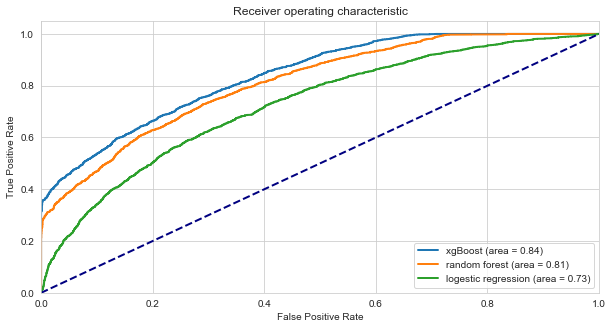

In [91]:
plt.figure(figsize=(10,5))
lw = 2
plt.plot(fpr_xgb, tpr_xgb,
         lw=lw, label='xgBoost (area = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_rf, tpr_rf,
         lw=lw, label='random forest (area = %0.2f)' % roc_auc_rf) 
plt.plot(fpr_lg, tpr_lg,
         lw=lw, label='logestic regression (area = %0.2f)' % roc_auc_lg)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

After evaluating the accuracy metric for all models, roc curve and auc metric shows us which model can perform better for all possible thresholds used by models for hard predictions. auc metric can also be interpreted as the probability of predicting a winner when he is indeed a winner, that means Xgboost can predict the winner with a probability of 0.84 .<br>
Using this graph, I can conclude that xgBoost is the best model I can select for predicting the 2017 tennis games.

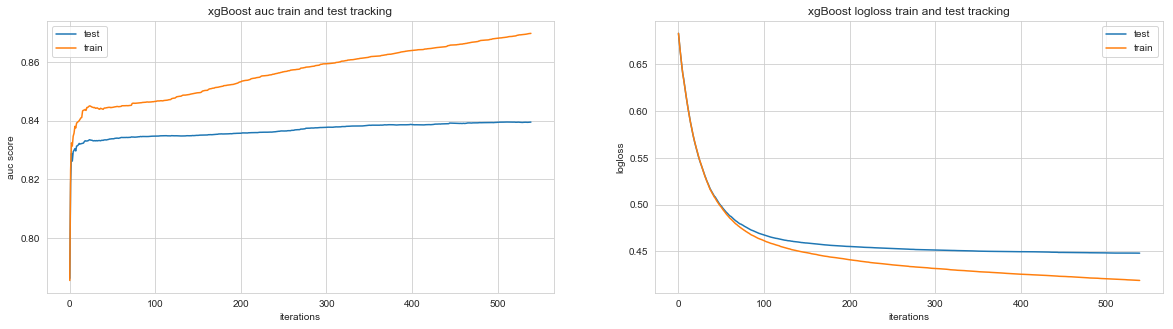

In [92]:
#xgboost train and validation tracking 
fig,axs = plt.subplots(1,2,figsize=(20,5))
y_auc_test = xgb.evals_result_['validation_1']['auc']
y_auc_train = xgb.evals_result_['validation_0']['auc']
y_logl_test = xgb.evals_result_['validation_1']['logloss']
y_logl_train = xgb.evals_result_['validation_0']['logloss']
n = len(y_logl_test)
iterations  = np.arange(n)

axs[0].plot(iterations,y_auc_test,'-')
axs[0].plot(iterations,y_auc_train,'-')
axs[0].set_title('xgBoost auc train and test tracking')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('auc score')
axs[0].legend(['test','train'])

axs[1].plot(iterations,y_logl_test,'-',label = 'test loss')
axs[1].plot(iterations,y_logl_train,'-',label = 'train auc')
axs[1].set_title('xgBoost logloss train and test tracking')
axs[1].set_xlabel('iterations')
axs[1].set_ylabel('logloss')
axs[1].legend(['test','train'])

plt.show()

### 8- conclusion

As we can see from the curves of our train and test tracking for xgBoost, there is no over/under fitting but our train set fails with a certain degree to statistically explain the test set.<br>
This may be due to the complexity of the problem itself as from the odds, ranks, points ,lags , past victories percentage, head to head and other features our train set still cannot statistically explain the test set.<br> Furthermore, our model is also based on odds, these odds does not reflect the correct odds of the winner and loser as they are regularized in a way that benefits the marchands, plus we still have a lot of missing values coming from the odds which is not in our model's favor.
Predicting the winner of a tennis match is not an easy task, it is related to many factors, features like : <B> <br>
weather, injuries and past injuries, age, percentage of 1st and second points won, faults, break points saved</B>, etc. <br>Using such features can probably give us better results but at this point I think this is the best outcome I can get from the current dataset.

### 9- Proof of concept : random drop won't have a significant effect on model training 

Earlier I have introduced randomness to drop one row at each two consecutive duplicated rows of the same match, in a way that our data loses the information
of winner and loser and our model will only see players as player1 vs player2 without letting any other possible leak for the training process.<br>
we might ask if the random generated vector that we used to drop our duplicated data may have a significant effect on the training and evaluation process.<br>
The aim of this part is to study the effect of random drop on our training process.

In [110]:
def random_drop(df):
    n = int(df.shape[0]/2)
    randomVector = np.random.randint(0,2,n)
    drop_index = np.zeros(n,dtype=np.int)

    j=0
    for i in range(0,new_tennis.shape[0],2):
        if randomVector[j] == 1 :
            drop_index[j] = i
        else :
            drop_index[j] = i+1        
        j+=1
    return drop_index

In [111]:
def training(df,model):
    #random winner/loser drop
    drop_index = random_drop(df)
    
    #train test split
    X_train,X_test,y_train,y_test = train_test_split(df.drop(index=drop_index,axis=0),2017,'player1 wins')

    #wta and atp accuracy masks
    atpMask = X_test.competition.apply(lambda x : True if x == 1 else False )
    wtaMask = X_test.competition.apply(lambda x : True if x == 0 else False )
    
    #training
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='auc',early_stopping_rounds=30,verbose=False)
    y_pred = model.predict(X_test)
    
    #evaluation
    overall = accuracy_score(y_pred,y_test)
    atp     = accuracy_score(y_pred[atpMask],y_test[atpMask])
    wta     = accuracy_score(y_pred[wtaMask],y_test[wtaMask])
    
    return overall,atp,wta

In [ ]:
#in this part I'm running the whole process 130 times to test if the random drop will have a significant effect on our model accuracy
n=130

xgb = XGBClassifier(learning_rate=0.033, max_depth=5, gamma=0,colsample_bytree=0.6,colsample_bylevel=0.9,subsample=1,n_estimators=1000,n_jobs=-1)
if 'player2 wins' in new_tennis_copy.columns :
    new_tennis_copy.drop('player2 wins',axis=1,inplace=True)

randAccuracy = {'overall':[],
                'atp':[],
                'wta':[]}

for i in tqdm(range(n)):
    overall,atp,wta = training(new_tennis_copy,xgb)
    randAccuracy['overall'].append(overall)
    randAccuracy['atp'].append(atp)    
    randAccuracy['wta'].append(wta)

In [149]:
#checkpoint
pd.DataFrame(randAccuracy).to_csv('accuracySample.csv',index=False)
accuracySample = pd.read_csv('./accuracySample.csv')
accuracySample.head()

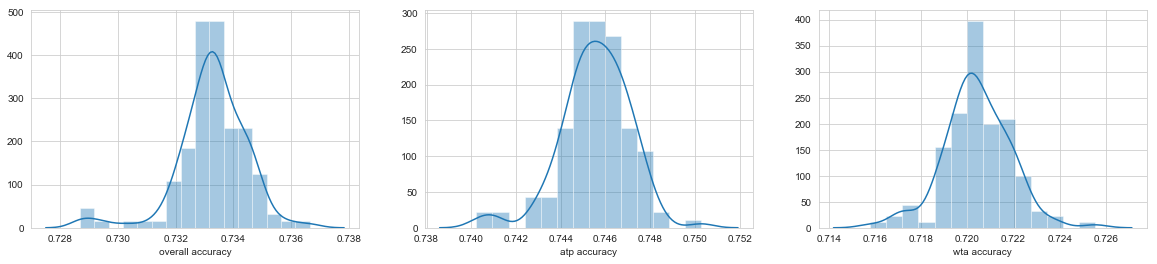

In [150]:
fig,axis = plt.subplots(1,3,figsize=(20,4))
sns.distplot(accuracySample.overall,ax=axis[0],axlabel='overall accuracy')
sns.distplot(accuracySample.atp,ax=axis[1],axlabel='atp accuracy')
sns.distplot(accuracySample.wta,ax=axis[2],axlabel='wta accuracy')
plt.show()

In [155]:
import scipy

# 0.05 p-value threshold 
print('goodness of fit test (normal distribution) for xgBoost overall accuracy    : pvalue = ',scipy.stats.normaltest(accuracySample.overall).pvalue)
print('goodness of fit test (normal distribution) for xgBoost ATP accuracy        : pvalue = ',scipy.stats.normaltest(accuracySample.atp).pvalue)
print('goodness of fit test (normal distribution) for xgBoost WTA accuracy        : pvalue = ',scipy.stats.normaltest(accuracySample.wta).pvalue)

goodness of fit test (normal distribution) for xgBoost overall accuracy    : pvalue =  5.973826900188196e-08
goodness of fit test (normal distribution) for xgBoost ATP accuracy        : pvalue =  0.0005326476405849499
goodness of fit test (normal distribution) for xgBoost WTA accuracy        : pvalue =  0.06252249294226721


Depending on the goodness of fit test, we can accept the null hypothesis (the distribution is normal) for WTA accuracy sample but we reject it for the overall and ATP samples accuracy.<br> I am confident that 100 other iterations or more can statistically give us an evidence that all three accuracy samples follow the normal distribution, but this process takes a lot of time. <br>I am going to assume that all three samples follow the normal distribution until more iterations are done to verify my assumption.

In [156]:
print('overall accuracy distribution for xgBoost   : mean = {:.3f} | std = {:.4f}'.format(accuracySample.overall.mean(),accuracySample.overall.std()))
print('ATP accuracy distribution for xgBoost       : mean = {:.3f} | std = {:.4f}'.format(accuracySample.atp.mean(),accuracySample.atp.std()))
print('WTA accuracy distribution for xgBoost       : mean = {:.3f} | std = {:.4f}'.format(accuracySample.wta.mean(),accuracySample.wta.std()))

overall accuracy distribution for xgBoost   : mean = 0.733 | std = 0.0012
ATP accuracy distribution for xgBoost       : mean = 0.746 | std = 0.0016
WTA accuracy distribution for xgBoost       : mean = 0.720 | std = 0.0015


After training our model 130 times, using at each time a different random drop vector, I am assuming that the accuracy samples follow a normal distribution.<br>
The means of the normal distributions are close to the accuracy we had when we trained Xgboost with a fixed seed(123) and the standard deviations are low, thus there won't be a huge effect caused by the random drop on our model training and evaluation.